# Importing the required stuff

In [1]:
# we import all the basic required libraries

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 

import numpy as np

import datetime as dt

In [2]:
# To remove warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Encoders
from sklearn.preprocessing import OneHotEncoder     # Nominal Categorical variables
from sklearn.preprocessing import StandardScaler     # Numerical variables

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
# importing multiple metrics so we can use calculate whatever is required later on.

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    log_loss
)

In [6]:
# reading the dataset
df = pd.read_csv('/kaggle/input/kaggle-dataset/kaggle-preprocessed.csv')

# Understanding our dataset

In [7]:
# Checking the first five rows
df.head()

,Unnamed: 0,Dataset_name,Author_name,Author_id,No_of_files,size,Type_of_file,Upvotes,Medals,Usability,Date,Day,Time,Dataset_link
0,0,Hotel Reservations Dataset,Ahsan Raza,https://www.kaggle.com/ahsan81,1,491 kB,CSV,315,Silver,10.0,1/04/2023,Wed,18:20:31,https://www.kaggle.com/datasets/ahsan81/hotel-...
1,2,Most Subscribed 1000 Youtube Channels,Mrityunjay Pathak,https://www.kaggle.com/themrityunjaypathak,1,29 kB,CSV,76,Bronze,10.0,1/21/2023,Sat,20:12:05,https://www.kaggle.com/datasets/themrityunjayp...
2,3,Olympics 124 years Dataset(till 2020),Nitish Sharma01,https://www.kaggle.com/nitishsharma01,3,5 MB,CSV,30,Bronze,10.0,2/01/2023,Wed,14:30:49,https://www.kaggle.com/datasets/nitishsharma01...
3,4,Medical Student Mental Health,The Devastator,https://www.kaggle.com/thedevastator,2,19 kB,CSV,37,Bronze,10.0,1/25/2023,Wed,06:30:14,https://www.kaggle.com/datasets/thedevastator/...
4,5,Latest Netflix TV shows and movies,Senapati Rajesh,https://www.kaggle.com/senapatirajesh,1,1 MB,CSV,94,Bronze,9.4,1/14/2023,Sat,22:33:12,https://www.kaggle.com/datasets/senapatirajesh...


In [8]:
# Checking the last five rows
df.tail()

,Unnamed: 0,Dataset_name,Author_name,Author_id,No_of_files,size,Type_of_file,Upvotes,Medals,Usability,Date,Day,Time,Dataset_link
9153,9966,bankdata,Jochein,https://www.kaggle.com/jochein,7,1 MB,"CSV, other",1,No Medal,1.8,12/31/2022,Sat,14:38:17,https://www.kaggle.com/datasets/jochein/bankdata
9154,9967,Simpsons Episodes & Ratings (1989-),Jonathan Bown,https://www.kaggle.com/jonbown,2,163 kB,CSV,42,Silver,10.0,12/27/2022,Tue,23:38:50,https://www.kaggle.com/datasets/jonbown/simpso...
9155,9968,Video Game Dataset,Trung Hoang,https://www.kaggle.com/jummyegg,1,22 MB,CSV,38,No Medal,8.2,12/23/2020,Wed,10:24:53,https://www.kaggle.com/datasets/jummyegg/rawg-...
9156,9969,deberta-v3-small,miwojc,https://www.kaggle.com/miwojc,6,600 MB,"other, JSON",3,No Medal,1.9,4/21/2022,Thu,11:43:36,https://www.kaggle.com/datasets/miwojc/deberta...
9157,9970,Israeli Premier League - Team stats 2016-20,Ido Yoely,https://www.kaggle.com/idoyo92,1,145 kB,CSV,4,No Medal,9.7,4/05/2020,Sun,14:23:01,https://www.kaggle.com/datasets/idoyo92/israel...


In [9]:
# checking the data summary
df.info

<bound method DataFrame.info of       Unnamed: 0                                 Dataset_name  \
0              0                   Hotel Reservations Dataset   
1              2        Most Subscribed 1000 Youtube Channels   
2              3        Olympics 124 years Dataset(till 2020)   
3              4                Medical Student Mental Health   
4              5           Latest Netflix TV shows and movies   
...          ...                                          ...   
9153        9966                                     bankdata   
9154        9967          Simpsons Episodes & Ratings (1989-)   
9155        9968                           Video Game Dataset   
9156        9969                             deberta-v3-small   
9157        9970  Israeli Premier League - Team stats 2016-20   

            Author_name                                   Author_id  \
0            Ahsan Raza              https://www.kaggle.com/ahsan81   
1     Mrityunjay Pathak  https://www.kaggle.c

In [10]:
df.shape

(9158, 14)

# Cleaning the data

In [11]:
# Checking for null values
df.isnull().sum()

Unnamed: 0      0
Dataset_name    0
Author_name     0
Author_id       0
No_of_files     0
size            0
Type_of_file    2
Upvotes         0
Medals          0
Usability       0
Date            0
Day             0
Time            0
Dataset_link    0
dtype: int64

In [12]:
# dropping null values
df =df.dropna()

In [13]:
# Checking for null values
df.isnull().sum()

Unnamed: 0      0
Dataset_name    0
Author_name     0
Author_id       0
No_of_files     0
size            0
Type_of_file    0
Upvotes         0
Medals          0
Usability       0
Date            0
Day             0
Time            0
Dataset_link    0
dtype: int64

**Basic cleaning has been done.  
There are no missing or duplicated values, we can proceed to the next step.**

In [14]:
# Checking for duplicated rows
df.duplicated().sum()

0

**There are no duplicated values.**

In [15]:
### Cleaning column names
df.columns = df.columns.str.lower()
df.columns

Index(['unnamed: 0', 'dataset_name', 'author_name', 'author_id', 'no_of_files',
       'size', 'type_of_file', 'upvotes', 'medals', 'usability', 'date', 'day',
       'time', 'dataset_link'],
      dtype='object')

# Feature Engineering

### Creating Date feature

In [16]:
# Converting date to datetime format
df['date'] = pd.to_datetime(df['date'])

# Getting year and month columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

### Extracting 'hour' from 'time' column.

In [17]:
# converting time into hours
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].dt.hour

In [18]:
# Dropping the date column
df.drop(columns='date', inplace=True)

### Standardizing the units of the 'size' column

In [19]:
# Checking all the storage format
df['size'].str[-2:].unique()

array(['kB', 'MB', ' B', 'GB'], dtype=object)

In [20]:
# Define the conversion factors for different units
units = {'KB': 1e-3, 'MB': 1, 'GB': 1e3, 'B': 1e-6, 'K': 1e-3}  # 'K' added for cases like '491 K'

# Function to clean and convert file sizes to MB
def convert_size(size_str):
    
    # Clean the string: remove spaces, standardize case
    size_str = size_str.strip().replace(' ', '').upper() 
    
    for unit in units:
        if unit in size_str:
            try:
                return float(size_str.replace(unit, '')) * units[unit]
            except ValueError:
                return 0  # In case of any unexpected formatting errors
    return 0  # Default to 0 if no valid unit is found

In [21]:
# Read the large CSV file in chunks and process each chunk
chunk_size = 10000
df_list = []  # List to store processed chunks

# Loop to read data in chunks
for start in range(0, len(df), chunk_size):
    end = min(start + chunk_size, len(df))  # Calculate the end of the chunk
    chunk = df.iloc[start:end]  # Slice the DataFrame to create a chunk
    
    # processing in chunks 
    chunk['size_in_mb'] = chunk['size'].apply(convert_size)
    
    # appending the processed chunk
    df_list.append(chunk)

# Concatenate all processed chunks into a final DataFrame
df = pd.concat(df_list)

print("Processing complete. The final dataset has been saved as 'processed_large_dataset.csv'.")

Processing complete. The final dataset has been saved as 'processed_large_dataset.csv'.


In [22]:
# Dropping size column
df.drop(columns='size', inplace=True)

# EDA - Exploratory Data Analysis

In [23]:
palette='rocket'

In [24]:
# Checking the years of the datasets.
list = df['year'].unique()
print(np.sort(list))

[2016 2017 2018 2019 2020 2021 2022 2023]


* **> our dataset contains datasets uploaded between the years 2016 and 2023**

Text(0.5, 1.0, 'Number of medals')

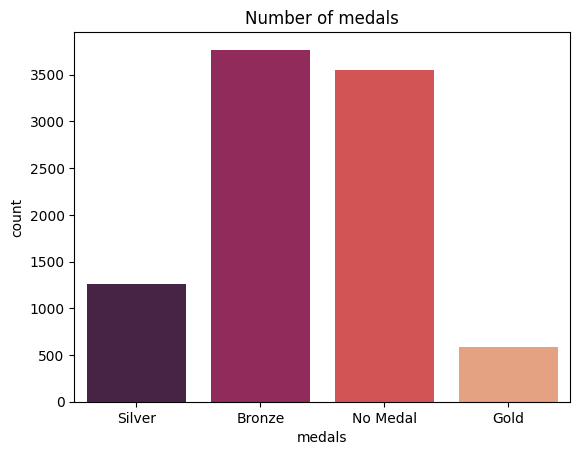

In [25]:
sns.countplot(x=df['medals'], palette=palette)
plt.title('Number of medals')

* **> Most datasets have Bronze medal, followed by No medal.**

Text(0.5, 1.0, 'Medal Distribution acc. to days')

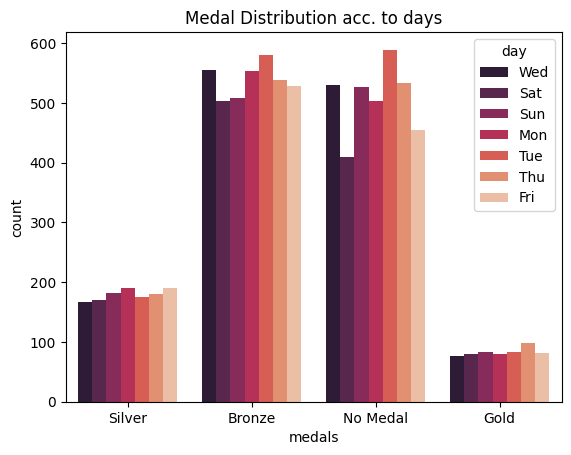

In [26]:
sns.countplot(x=df['medals'], hue=df['day'], palette=palette)
plt.title('Medal Distribution acc. to days')

* **> We can see that most of the Gold medal datasets were uploaded on Thursdays.**
* **> And most Silvers on Monday.**

<Axes: xlabel='usability', ylabel='Count'>

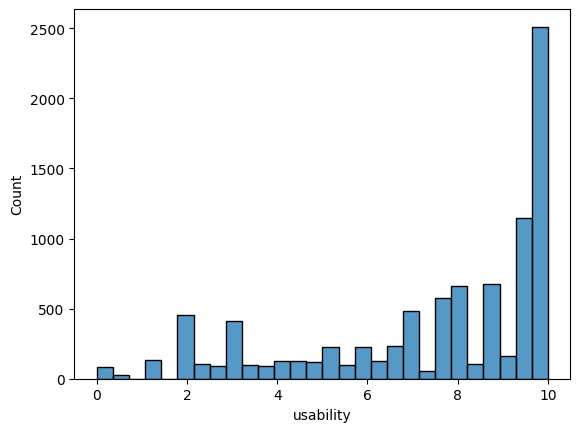

In [27]:
sns.histplot(data=df['usability'])

* **> The usability scores are negatively skewed.**

Text(0.5, 1.0, 'Medals acc to size in mb')

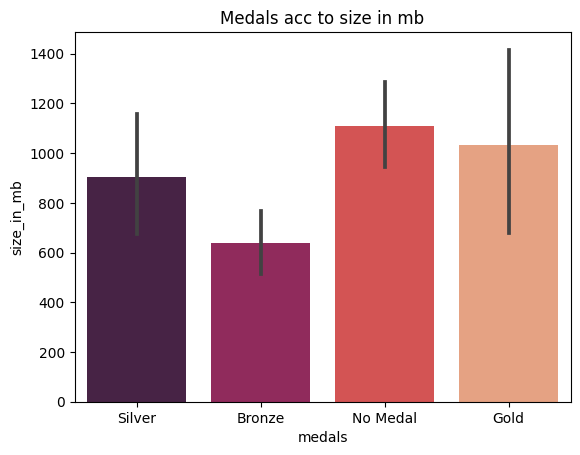

In [28]:
sns.barplot(x=df['medals'], y=df['size_in_mb'], palette=palette)
plt.title('Medals acc to size in mb')

* **> We can see that on an average, files around 1000 mb got the most number of silver medals.**

# Feature Selection

In [29]:
# Droppping unecessary columns
df.drop(columns=['unnamed: 0', 'dataset_name', 'author_name', 'author_id', 'dataset_link'], inplace=True)

In [30]:
# getting column names
df.columns

Index(['no_of_files', 'type_of_file', 'upvotes', 'medals', 'usability', 'day',
       'time', 'year', 'month', 'size_in_mb'],
      dtype='object')

# Pre-Processing

## Encoding & Scaling the features

In [31]:
# Getting categorical columns
categorical_features = df.select_dtypes(include='object').columns
numerical_features = [item for item in df.columns if item not in categorical_features]

In [32]:
# Encoding Nominal Features
# Nominal features - have an order of ranking

# Manual Mapping
df['medals'] = df['medals'].map({'No Medal': 0, 'Bronze': 1, 'Silver': 2, 'Gold': 3})

# We don't use Label ENcoder as it maps the data in alphabetical order.
# We will not have complete control.
# But manual mapping gives me control to assign highest value to Gold and the least value to No Medal

In [33]:
# Dropping medals cos we already encoded it.
categorical_features = df[categorical_features].drop(columns='medals').columns

In [34]:
# Encoding the catogorical nominal features
encoder = OneHotEncoder(sparse=False)

for feature in categorical_features:
    df[feature] = encoder.fit_transform(df[[feature]])

    
# 'sparse=1': saves memory by only storing non-zero values

In [35]:
# Scaling numeric features
encoder = StandardScaler()

for feature in numerical_features:
    df[feature] = encoder.fit_transform(df[[feature]])

## Train-Test Split

In [36]:
# Extracting the target variable as X and the remaining features as Y

Y = df['medals']
X = df.drop(columns='medals')

In [37]:
# we create a train test split with as 80% and 20%.
# we used random state ro enable replicability of the results

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=66)

## Oversampling

**we use oversampling in order to make sure that all the medal categories are equally represented in the model in order to try and minimize bias.**

In [38]:
# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=60)

# Fit and resample
X_resampled, y_resampled = ros.fit_resample(x_train, y_train)

In [39]:
# CHecking the number of samples taken
values, count = np.unique(y_resampled, return_counts=True)

In [40]:
print(f'Unique values of medals: {values}')
print(f'No. of samples taken from each: {values}')

Unique values of medals: [0 1 2 3]
No. of samples taken from each: [0 1 2 3]


# Modelling

## Initialising Model

In [41]:
# initializing the model using random state in order to get consistent results.

model = RandomForestClassifier(random_state=60)

## Training the model

In [42]:
# fitting the model with the resampled data
model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=60)

## Predicting

In [43]:
y_pred = model.predict(x_test)

## Model Evaluation

In [44]:
metrics = {'precision': precision_score,
           'recall':recall_score}

In [45]:
for name, metric in metrics.items():
    print(name, ' : ', metric(y_test, y_pred, average='weighted'))

precision  :  0.765162012599431
recall  :  0.7592794759825328


## Understanding the Model

In [46]:
# to get the values of importance of features in the model.
feature_importances = model.feature_importances_

In [47]:
#getting a list of all the feature names
feature_names = x_train.columns

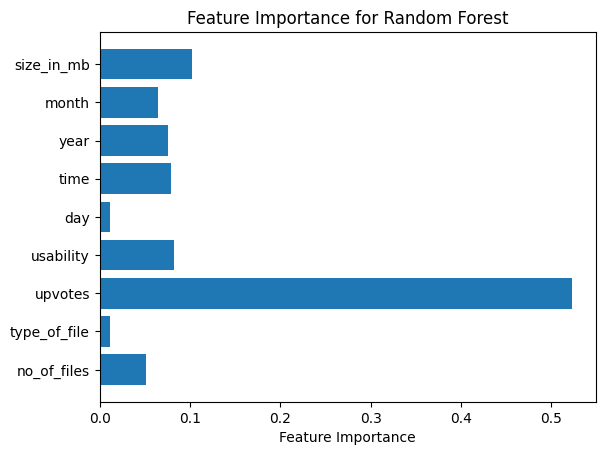

In [48]:
# plotting the feature importances
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Random Forest")
plt.show()

# Conclusion:

**> We can safely say that the number of updates has the highest impact in deciding the medal that the model will receive.**

**> The second most important factor being the size of the file.
(Files having the size around 1GB seem to get most Gold medals.)**